# Manuscript analysis and figures

This notebook contains code to analyze results and generate figures for the paper __[Kinetic sequencing (*k*-Seq) as a massively parallel assay for ribozyme kinetics: utility and critical parameters](https://www.biorxiv.org/content/10.1101/2020.12.02.407346v1)__

## Environment setup

Set up the workspace environment

In [1]:
# Path to the core data from our Dryad archive (unzip from core-data.tar.gz)
PAPER_DATA_DIR = '/Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/'

# Path to output figures
FIG_OUTPUT_DIR = '/Users/yuning/Desktop/kseq-NAR-revision-fig'

# Path to k-seq repository snapshot (load k_seq package locally)
# It should be core-data/code
K_SEQ_REP_DIR = '/Users/yuning/research/k-seq/'

# display resolution
DISP_RES = 80

In [2]:
# You wouldn't need to change this part

## Jedi autocompletion performs funky in Jupyter notebook, disable it
from IPython import get_ipython
get_ipython().Completer.use_jedi = False
get_ipython().Completer.limit_to__all__ = True


## Add repo path to load k-seq package locally (paper version)
from pathlib import Path
import sys
sys.path.insert(0, str(Path(K_SEQ_REP_DIR) / 'src'))
import k_seq
## Link data path and figure output path 
import os
os.environ['PAPER_DATA_DIR'] = PAPER_DATA_DIR
if PAPER_DATA_DIR != '':
    Path(FIG_OUTPUT_DIR).mkdir(exist_ok=True, parents=True)

import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = DISP_RES

marker_map = {'0': 'o', '1': 'o', '2': '^', '3': 's'}
color_map = {'R': '#AEAEAE', 'A': '#2C73B4', 'B': '#70C7C7',
             'C': '#1C7725', 'D':'#F39730', 'E': '#B2112A'}
from k_seq.utility import plot_tools
default_palette = plot_tools.Presets.color_cat10
label_map = {'A': '1250 μM', 'B': '250 μM', 'C': '50 μM', 
             'D': '10 μM', 'E': '2 μM',
             'R': 'Unreacted'}

/Users/yuning/miniconda3/envs/k-seq/lib/python3.8/site-packages/IPython/core/completer.py:1044: UserWarning: `IPython.core.IPCompleter.limit_to__all__` configuration value has been deprecated since IPython 5.0, will be made to have no effects and then removed in future version of IPython.
  warnings.warn('`IPython.core.IPCompleter.limit_to__all__` configuration '


In [3]:
# function to load k-seq results

def load_variant_pool():
    if 'variant_pool' not in globals().keys():
        print('loading variant_pool')
        from k_seq.utility import file_tools
        global variant_pool
        variant_pool = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-variant/byo-variant.pkl")
        variant_pool.update_analysis()
    else:
        print('variant_pool found')
    
    if 'variant_pool_res' not in globals().keys():
        print('loading variant_pool_res')
        from k_seq.estimate.least_squares_batch import BatchFitResults
        global variant_pool_res
        variant_pool_res = BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/all-seq_bs-100')
    else:
        print('variant_pool_res found')

        
def load_enriched_pool():
    if 'enriched_pool' not in globals().keys():
        from k_seq.utility import file_tools
        print('loading enriched_pool')
        global enriched_pool
        enriched_pool = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-enriched/byo-enriched.pkl")
        enriched_pool.update_analysis()
    else:
        print('enriched_pool found')
    
    if 'enriched_pool_res' not in globals().keys():
        print('loading enriched_pool_res')
        from k_seq.estimate.least_squares_batch import BatchFitResults
        global enriched_pool_res
        enriched_pool_res = BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-enriched/all-seq_bs-100')
    else:
        print('enriched_pool_res found')

def load_simu_count():
    if 'simu_count' not in globals().keys():
        print('loading simu_count')
        from k_seq.data import simu
        global simu_count
        simu_count = simu.SimulationResults(
            dataset_dir=f"{PAPER_DATA_DIR}/results/simu-count/simu-count.pkl",
            result_dir=f'{PAPER_DATA_DIR}/results/simu-count/all-seq_bs-100/'
        )
    else:
        print('simu_count found')

## Figure 2: model identifiability

In [4]:
# define plotting functions
from k_seq.estimate import model_ident

def add_kA_curve(kA_const, ax, **kwargs):
    """Add auxilary kA = constant curve"""
    xlim = ax.get_xlim()
    k = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 100)
    A = kA_const / k
    ax.plot(k, A, **kwargs)
    ax.text(s=f'    $kA$={kA_const}', x=kA_const, y=0.9, ha='left', va='top',
            color='w', weight='bold', fontsize=8)
    
def hexmap_compare(results, metric, gridsize, clabel, **plot_kwargs):
    """multiple hexplot to compare model identifiability results"""
    
    fig, axes = plt.subplots(1, len(results),
                             figsize=(3 * len(results), 3),
                             sharey=True)
    
    for ix, (ax, (name, result)) in enumerate(zip(axes, results.items())):
        if ix == (len(results) - 1):
            ax, cax = result.plot_map(metric=metric, gridsize=gridsize,
                                      ax=ax, **plot_kwargs)
            cax.set_ylabel(clabel, fontsize=12)
        else:
            ax = result.plot_map(metric=metric, gridsize=gridsize, cax_pos=None,
                                 ax=ax, **plot_kwargs)
        ax.set_title(name, fontsize=12)
        if ix > 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel('True $A$')
        ax.set_xlabel('')
        
        add_kA_curve(kA_const=0.1, ax=ax, color='w', alpha=0.8, ls='--')
        add_kA_curve(kA_const=1, ax=ax, color='w', alpha=0.8, ls='--')
        add_kA_curve(kA_const=10, ax=ax, color='w', alpha=0.8, ls='--')
    fig.text(s='True $k$', x=0.5, y=0, ha='center', va='top', fontsize=12)
    return fig

    
def gamma(row):
    """gamma (adjusted log ratio of k and kA), see paper for details"""
    return np.log10(row['bs_k_std'] * row['bs_A_mean'] / row['bs_kA_std'])

INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/standard-relErr02...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/additional-relErr02...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr02...
INFO:root:'seqs.tar.gz' found


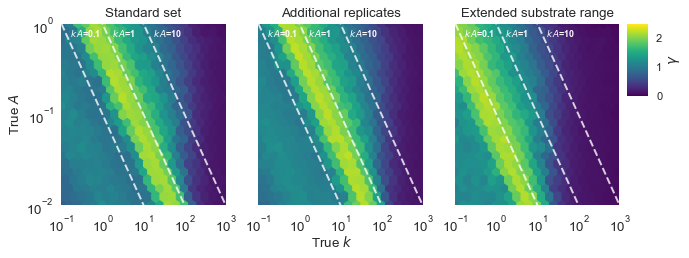

In [5]:
sample_effects = {
    'Standard set': model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/standard-relErr02'),
    'Additional replicates': model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/additional-relErr02'),
    'Extended substrate range': model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr02')
}

fig = hexmap_compare(
        results=sample_effects, metric=gamma, gridsize=20,
        clabel='$\\gamma$', vmin=0, vmax=2.5
)
if FIG_OUTPUT_DIR != '':
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-2a.pdf', bbox_inches='tight')

INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr0...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr02...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr05...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr10...
INFO:root:'seqs.tar.gz' found


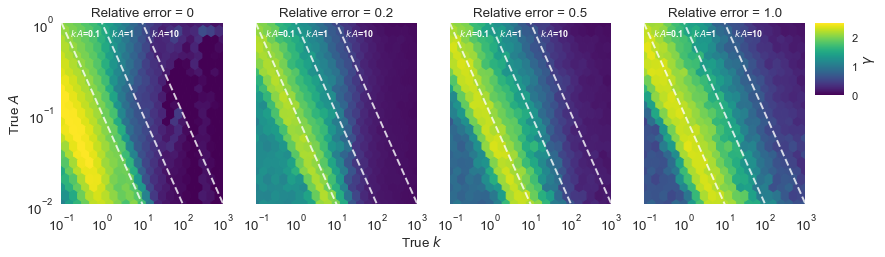

In [6]:
noise_effects = {
    'Relative error = 0': model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr0/'),
    'Relative error = 0.2':model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr02/'),
    'Relative error = 0.5':model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr05/'),
        'Relative error = 1.0':model_ident.ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr10/')
}

fig = hexmap_compare(
        results=noise_effects, metric=gamma, gridsize=20,
        clabel='$\\gamma$', vmin=0, vmax=2.5
)
if FIG_OUTPUT_DIR != '':
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-2b.pdf', bbox_inches='tight')

## Figure 3: total DNA amount from spike-in or qPCR

In [7]:
load_variant_pool()

dna_amount = pd.DataFrame({
    'total amount (spike-in, ng)': variant_pool.spike_in.norm_factor * variant_pool.table.filtered.sum(axis=0),
    'total amount (sample total, ng)': pd.Series(variant_pool.sample_total.norm_factor) * variant_pool.table.filtered.sum(axis=0)
})
dna_amount

loading variant_pool


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/experimental/byo-variant/all-seq_bs-100...


loading variant_pool_res


INFO:root:'seqs.tar.gz' found


,"total amount (spike-in, ng)","total amount (sample total, ng)"
A1,134.999489,123.000005
A2,169.042017,128.000000
A3,277.091204,182.000016
B1,153.618984,115.000002
B2,148.938599,111.499998
B3,143.576737,97.999996
C1,78.639203,50.000000
C2,51.897738,34.500000
C3,64.911971,46.000001
D1,17.421282,10.788097


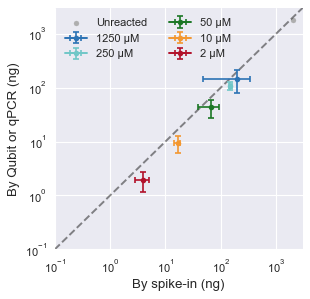

Pearson r: 0.999, p-val: 2.39e-21


In [8]:
# plot alignment of two DNA quantification methods
fig, ax = plt.subplots(1,1, figsize=(4, 4))
error_bar = 1.96

for byo, color in color_map.items():
    samples = [sample for sample in dna_amount.index if sample[0] == byo]
    x_mean = dna_amount.loc[samples, 'total amount (spike-in, ng)'].mean()
    x_sd = dna_amount.loc[samples, 'total amount (spike-in, ng)'].std()
    y_mean = dna_amount.loc[samples, 'total amount (sample total, ng)'].mean()
    y_sd = dna_amount.loc[samples, 'total amount (sample total, ng)'].std()
    
    if byo == 'R': # unreacted, no replicates
        ax.scatter(x=[x_mean], y=[y_mean],
                   marker='o', s=20, color=color, label=label_map[byo])
    else:
        ax.errorbar(x=[x_mean], xerr=error_bar * x_sd,
                    y=[y_mean], yerr=error_bar * y_sd,
                    marker='o', markersize=5, color=color, elinewidth=1.5, capsize=3,
                    capthick=1.5, label=label_map[byo])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1, 3000])
ax.set_ylim([0.1, 3000])
ax.legend(loc='upper left', ncol=2)

xs = np.logspace(np.log10(0.1), np.log10(3000), 20)
ax.plot(xs, xs, '#151515', alpha=0.5, ls='--', zorder=1)
ax.set_xlabel('By spike-in (ng)', fontsize=12)
ax.set_ylabel('By Qubit or qPCR (ng)', fontsize=12)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-3.pdf', bbox_inches='tight')
plt.show()

# calculate pearson correlation
from scipy import stats
pearson_r = stats.pearsonr(dna_amount['total amount (spike-in, ng)'], dna_amount['total amount (sample total, ng)'])
print(f"Pearson r: {pearson_r[0]:.3f}, p-val: {pearson_r[1]:.2e}")

## Figure 4: doped pool design and effect of sequencing error
### Figure 4A: count distribution in the unreacted pool

In [9]:
load_variant_pool()
# calculate counts for sequences in each order of mutants

mega_peak = variant_pool.pool_peaks_merged
classes = {
    '$d = 0$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 0].index],
    '$d = 1$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 1].index],
    '$d = 2$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 2].index],
    '$d = 3$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 3].index],    
    '$d = 4$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 4].index],
    '$d \geq 5$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center >= 5].index]
}

classes['$d = 0$']

variant_pool found
variant_pool_res found


CTACTTCAAACAATCGGTCTG    1383177.0
CCACACTTCAAGCAATCGGTC    1184455.0
ATTACCCTGGTCATCGAGTGA    1057445.0
AAGTTTGCTAATAGTCGCAAG    1348922.0
Name: R0, dtype: float64

In [10]:
print(f'Total number of reads: {int(variant_pool.table.filtered.R0.sum()):,d}')

Total number of reads: 32,931,917


In [11]:
from k_seq.data.variant_pool import d_mutant_fraction

# expected counts for sequences in each order of mutants
E_counts = [
    d_mutant_fraction(d, mutation_rate=0.09) * variant_pool.table.filtered.R0.sum() / 4 
    for d in [0, 1, 2, 3, 4]
]
E_counts

[1136125.374484239,
 37454.682675304575,
 1234.7697585265246,
 40.70669533603926,
 1.3419789671221731]

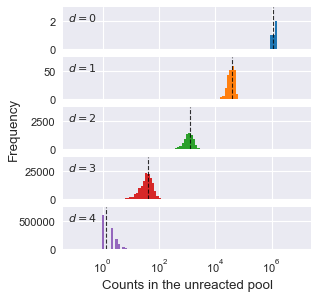

In [12]:
# expected counts given unreacted pool total counts
fig, axes = plt.subplots(5, 1, figsize=(4, 4), sharex=True)
fig.subplots_adjust(hspace=0.2)

bins = np.logspace(-1, 7, 100)

for ix, ((cls_name, cls_seqs), E_count, color) in enumerate(zip(classes.items(), E_counts, default_palette(num=5))):
    ax = axes[ix]
    ax.hist(cls_seqs, bins=bins, color=color)
    
    y_lim = ax.get_ylim()
    rounded_ticks = 10 ** int(np.log10(y_lim[1]) + 1) / 2
    if rounded_ticks > y_lim[1]:
        rounded_ticks = int(rounded_ticks / 2)
    ax.set_yticks([0, rounded_ticks])
    ax.set_ylim([0, rounded_ticks * 1.5])
    
    y_lim = ax.get_ylim()
    ax.plot([E_count, E_count], [0, y_lim[1]], 'k--', alpha=0.8, lw=1)
    ax.set_ylim(y_lim)
    
    ax.set_xscale('log')
    ax.text(x=0.02, y=0.9, s=cls_name, ha='left', va='top',
            fontsize=10, transform=ax.transAxes)
    
    ax.tick_params(labelsize=10)

fig.text(x=-0.01, y=0.5, s='Frequency', ha='right', va='center', fontsize=12, rotation=90)
ax.set_xlabel('Counts in the unreacted pool', fontsize=12)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-4a.pdf', bbox_inches='tight')
plt.show()

### Figure4b: sequencing error effects in determining variant pool abundance

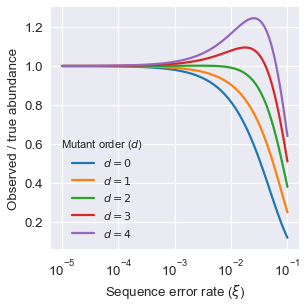

In [13]:
from k_seq.data.variant_pool import neighbor_effect_observation

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for d, color in zip([0, 1, 2, 3, 4], default_palette(num=5)):
    xi = np.logspace(-5, -1, 100)
    ax.plot(xi, neighbor_effect_observation(xi, d=d), label=f'$d = {d}$', lw=2, color=color)

ax.set_xlabel('Sequence error rate ($\\xi$)', fontsize=12)
ax.set_ylabel('Observed / true abundance', fontsize=12)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='Mutant order ($d$)')
ax.tick_params(labelsize=12)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-4b.pdf', bbox_inches='tight')
plt.show()

## Table 1: coverage of each mutants

In [14]:
from k_seq.data.variant_pool import d_mutant_fraction

def survey_seq_d_dist(seqs, d, analyzable_table, count_table, n_peak=4):
    from k_seq.data.variant_pool import num_of_seq
    analyzable_seq = analyzable_table.loc[analyzable_table.index.isin(seqs)].index
    if d is None:
        possible_seqs = None
    else:
        possible_seqs = num_of_seq(length=21, letter_book_size=4, d=d) * n_peak
    
    return {
        'num. unique seqs': None if possible_seqs is None else int(possible_seqs),
        'detected seqs': len(seqs),
        'num. analyzable seqs': len(analyzable_seq),
        'coverage': None if possible_seqs is None else len(seqs) / possible_seqs,
        'analyzable coverage': None if possible_seqs is None else len(analyzable_seq) / possible_seqs,
        'input_counts_mean': count_table['R0'][seqs].mean(),
        'input_counts_sd': count_table['R0'][seqs].std(),
        'expected_counts': None if d is None else d_mutant_fraction(d, mutation_rate=0.09) * count_table.R0.sum() / 4
    }

if 'classes' not in locals().keys():
    classes = {
        '$d = 0$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 0].index],
        '$d = 1$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 1].index],
        '$d = 2$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 2].index],
        '$d = 3$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 3].index],    
        '$d = 4$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center == 4].index],
        '$d \geq 5$': variant_pool.table.filtered.R0[mega_peak.dist_to_center[mega_peak.dist_to_center >= 5].index]
    }

class_summary = pd.DataFrame.from_dict({
    clas: survey_seq_d_dist(
        seqs=seqs.index, d=d, 
        analyzable_table=variant_pool.table.reacted_frac_qpcr,
        count_table=variant_pool.table.filtered
    ) for (clas, seqs), d in zip(classes.items(), [0, 1, 2, 3, 4, None])
}, orient='index')

class_summary.index.name = 'order of mutants'
class_summary

,num. unique seqs,detected seqs,num. analyzable seqs,coverage,analyzable coverage,input_counts_mean,input_counts_sd,expected_counts
order of mutants,,,,,,,,
$d = 0$,4.0,4,4,1.000000,1.000000,1.243500e+06,151356.353751,1.136125e+06
$d = 1$,252.0,252,252,1.000000,1.000000,3.759993e+04,10607.142262,3.745468e+04
$d = 2$,7560.0,7560,7560,1.000000,1.000000,1.198271e+03,454.833702,1.234770e+03
$d = 3$,143640.0,143638,143482,0.999986,0.998900,3.974957e+01,18.888826,4.070670e+01
$d = 4$,1939140.0,1522094,590115,0.784932,0.304318,1.688681e+00,1.294647,1.341979e+00
$d \geq 5$,NaN,1616787,23343,NaN,NaN,7.075298e-01,0.526965,NaN


In [15]:
def print_style(df):
    df = df.copy(deep=True)
    for col in ['num. unique seqs', 'detected seqs', 'num. analyzable seqs']:
        df[col] = df[col].apply(lambda x: f"{int(x):,d}" if not np.isnan(x) else np.nan)
    for col in ['coverage', 'analyzable coverage', 'expected_counts']:
        df[col] = df[col].apply(lambda x: f"{x:,.3f}")
    df['input_counts'] = df['input_counts_mean'].apply(lambda x: f"{x:,.2f}") + ' (' + df['input_counts_sd'].apply(lambda x: f"{x:,.2f}") + ')'
    return df.drop(columns=['input_counts_mean', 'input_counts_sd'])

print_style(class_summary)

,num. unique seqs,detected seqs,num. analyzable seqs,coverage,analyzable coverage,expected_counts,input_counts
order of mutants,,,,,,,
$d = 0$,4,4,4,1.000,1.000,"1,136,125.374","1,243,499.75 (151,356.35)"
$d = 1$,252,252,252,1.000,1.000,"37,454.683","37,599.93 (10,607.14)"
$d = 2$,"7,560","7,560","7,560",1.000,1.000,"1,234.770","1,198.27 (454.83)"
$d = 3$,"143,640","143,638","143,482",1.000,0.999,40.707,39.75 (18.89)
$d = 4$,"1,939,140","1,522,094","590,115",0.785,0.304,1.342,1.69 (1.29)
$d \geq 5$,NaN,"1,616,787","23,343",nan,nan,nan,0.71 (0.53)


## Figure 5: accuracy

### Figure 5a

In [16]:
def scatter_ratio_to_truth(df_res, df_truth, xcol, seq_list=None, ycol='ka', cap_by=100, fold_guide_lines=(1.1, 10),
                   markercolor='#2C73B4', alpha=0.3,
                   xlog=False, ylog=False, xlabel=None, ylabel=None, xlim=None, ylim=None,
                   markersize=5, ax=None, figsize=None, fontsize=14):
    """Scatterplot of error distribution with respect to a given x axis
    Args:
        df_res (pd.DataFrame): table of results from estimation
        df_truth (pd.DataFrame): table of ground truth to compare with
        xcol (str): column name in df_truth to use as x axis
        ycol (str or tuple (str, str)): column name(s) in df_res and df_truth to compare
        percent_error (bool): if calculate percent error based on the true values
    """
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize if figsize else [8, 4])
    
    if isinstance(ycol, str):
        # if y column name is same in the results and truth table
        ycol = (ycol, ycol)
    
    if seq_list is not None:
        df_res = df_res.loc[seq_list]
        df_truth = df_truth.loc[seq_list]
    
    est = df_res[ycol[0]]
    truth = df_truth[ycol[1]]
    ratio = est / truth
    ratio[ratio > cap_by] = cap_by
    ratio[ratio < 1/cap_by] = 1/cap_by
    ylabel_prefix = 'Estimation / truth for'
    x = df_truth[xcol]
    ax.scatter(x, ratio, color=markercolor, marker='.', s=markersize, alpha=alpha)
    
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel if xlabel else xcol, fontsize=fontsize)
    ax.set_ylabel(ylabel if ylabel else f"{ylabel_prefix} ${ycol[0]}$", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    
    if not xlim:
        xlim = ax.get_xlim()
    if fold_guide_lines:
        if isinstance(fold_guide_lines, (int, float, tuple)):
            fold_guide_lines = [fold_guide_lines]
        for fold_guide_line in fold_guide_lines:
            if isinstance(fold_guide_line, tuple):
                value, label = fold_guide_line[0], fold_guide_line[1]
            else:
                value, label = fold_guide_line, str(fold_guide_line)
            ax.plot(xlim, (value, value), 'k--', alpha=0.5, lw=1)
            ax.text(s=label, x=xlim[1], y=value, ha='left', va='center', fontsize=fontsize - 6)

    ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()

loading simu_count


INFO:root:1000000 sequences simulated, 602268 fitted, 602246 has valid results


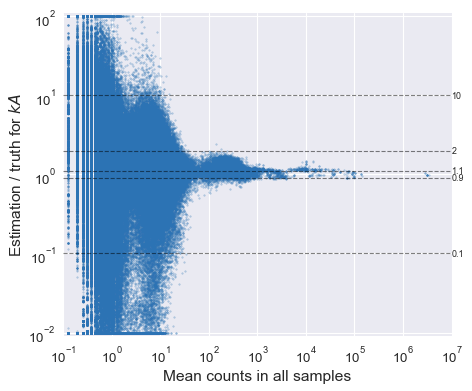

In [17]:
load_simu_count()
scatter_ratio_to_truth(
    df_res=simu_count.results, df_truth=simu_count.truth, seq_list=simu_count.seq_list, xcol='mean_counts', ycol=('kA', 'kA'),
    xlog=True, ylog=True, xlabel='Mean counts in all samples',
    ylim=(1e-2 / 1.1, 1e2 * 1.1), xlim=(1e-1, 1e7), figsize=(6, 5), markersize=10,
    cap_by=100, fold_guide_lines=[0.1, 0.9, 1.1, 2, 10],
)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-5a.png', dpi=600, bbox_inches='tight')

### Figure 5b

In [19]:
def get_bootstrap_accuracy(bs_result, truth, bs_param='bs_kA', truth_param='kA'):
    """Return a dataframe include if the bootstrap result (95-percenile) includes the true value"""
    
    result = bs_result[[bs_param + '_2.5%', bs_param + '_97.5%']]
    result = pd.concat([
        result,
        truth.reindex(result.index)[[truth_param, 'mean_counts', 'input_counts']].rename(columns={truth_param: truth_param + '_truth'})], axis=1)
    result['fold_range'] = result[bs_param + '_97.5%'] / result[bs_param + '_2.5%']
    result['in_ci95'] = ((result[truth_param + '_truth'] >= result[bs_param + '_2.5%']) & (result[truth_param + '_truth'] <= result[bs_param + '_97.5%'])).astype('int')
    
    return result


def uncertainty_accuracy_seq_bins(accuracy, bin_by, bin_size=25000):
    accuracy = accuracy.sort_values(by=bin_by, ascending=False) # from highest to lowest
    bin_num = int(accuracy.shape[0] / bin_size)
    acc_list = [accuracy.iloc[ix * bin_size : (ix + 1) * bin_size]['in_ci95'].mean() for ix in range(bin_num)]
    N_list = [(ix + 1) * bin_size for ix in range(bin_num)]
    return acc_list, N_list, accuracy


def plot_uncertainty_accuracy_seq_bins(result, bin_by, pred_types, 
                                       param='kA', bin_by_label=None, bin_size=1000, 
                                       ax=None, figsize=(6, 4), fontsize=12):
    
    composed = {}
    # line plot
    ax = plot_tools.ax_none(ax=ax, figsize=figsize)
    color_list = plot_tools.Presets.color_tab10(len(pred_types))
    
    if isinstance(pred_types, (list, tuple)):
        pred_types = {pred_type: pred_type for pred_type in pred_types}
    
    for (pred_type_label, pred_type), color in zip(pred_types.items(), color_list):
        acc_list, N_list, accuracy = uncertainty_accuracy_seq_bins(
            accuracy=result.get_uncertainty_accuracy(param=param, pred_type=pred_type),
            bin_by=bin_by, bin_size=bin_size
        )
        composed[pred_type_label] = np.mean(accuracy['in_ci95'])
        
        ax.plot(N_list, acc_list, '-o', markersize=5, color=color, alpha=0.5, label=pred_type_label)
    
    
    ax.set_xlabel(f'Sequences (ordered by {bin_by if bin_by_label is None else bin_by_label})',
                  fontsize=fontsize)
    ax.set_ylabel('Fraction of truth in CI-95', 
                  fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [0.95, 0.95], 'k', ls='--', alpha=0.5, zorder=1)
    ax.set_xlim(xlim[0], xlim[1])
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    ax.legend()
    return ax

simu_count found


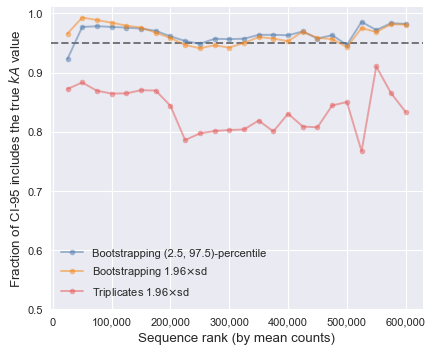

In [20]:
load_simu_count()

ax = plot_uncertainty_accuracy_seq_bins(
    result=simu_count,
    bin_by='mean_counts', bin_by_label='mean counts',
    pred_types={'Bootstrapping (2.5, 97.5)-percentile':'bs_ci95',
                "Bootstrapping 1.96$\\times$sd":'bs_sd',
                "Triplicates 1.96$\\times$sd": 'rep_sd'},
    param='kA', bin_size=25000, figsize=(6, 5)
)

from matplotlib import ticker
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax.set_xlabel('Sequence rank (by mean counts)')
ax.set_ylabel('Fraction of CI-95 includes the true $kA$ value')
ax.set_ylim(0.5, 1.01)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-5b.pdf', bbox_inches='tight')

## Figure 6: precision

### Figure 6a

In [21]:
def get_result_summary(data, result):
    allowed_col = [
        'k', 'A', 'kA',
        'A_mean', 'k_mean', 'kA_mean',
        'A_std', 'k_std', 'kA_std',
        'A_2.5%', 'k_2.5%', 'kA_2.5%',
        'A_50%', 'k_50%', 'kA_50%',
        'A_97.5%', 'k_97.5%', 'kA_97.5%',
        'bs_A_mean', 'bs_k_mean', 'bs_kA_mean',
        'bs_A_std', 'bs_k_std', 'bs_kA_std',
        'bs_A_2.5%', 'bs_k_2.5%', 'bs_kA_2.5%',
        'bs_A_50%', 'bs_k_50%', 'bs_kA_50%',
        'bs_A_97.5%', 'bs_k_97.5%', 'bs_kA_97.5%',
        'rep_A_mean', 'rep_k_mean', 'rep_kA_mean',
        'rep_A_std', 'rep_k_std', 'rep_kA_std'
    ]
    from k_seq.estimate import BatchFitResults
    if isinstance(result, BatchFitResults):
        result = result.summary

    cols = result.columns[result.columns.isin(allowed_col)]
    seq_list = result.index[~result.loc[:, result.columns.isin(allowed_col)].isna().any(axis=1)]

    result = result.loc[seq_list, cols]
    result['kA_fold_range'] = result['bs_kA_97.5%'] / result['bs_kA_2.5%']
    result['dist_to_center'] = data.pool_peaks_merged.dist_to_center[seq_list]
    result['input_counts'] = data.table.original[data.grouper.input.group].median(axis=1)[seq_list]
    result['mean_counts'] = data.table.original.mean(axis=1)[seq_list]
    return result


def scatter_plot_results_on_mutation_dist(result, x, y, x_label, y_label, x_lim, y_lim, x_log=True, y_log=True, top_group_size=int(1e4), top_y_values=None, fontsize=14, figsize=(6, 5)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    w_list = {'$d = 0$': lambda df: df['dist_to_center'] == 0,
              '$d = 1$': lambda df: df['dist_to_center'] == 1,
              '$d = 2$': lambda df: df['dist_to_center'] == 2,
              '$d = 3$': lambda df: df['dist_to_center'] == 3,
              '$d \geq 4$': lambda df: df['dist_to_center'] >= 4}

    color_list = plot_tools.Presets.color_tab10(len(w_list))

    for ix, ((label, filter_fn), color) in enumerate(zip(w_list.items(), color_list)):
        seq_list = result[filter_fn(result)].index
        if len(seq_list) > top_group_size:
            seq_list = seq_list.to_series().sample(top_group_size)
        x_series = result.loc[seq_list, x]
        y_series = result.loc[seq_list, y]
        if top_y_values is not None:
            y_series[y_series > top_y_values] = top_y_values
        ax.scatter(x_series, y_series,
                   marker='o', s=20 -  ix ** 2, color=color, label=label, alpha=1 - 0.15 * ix, zorder = 8 - ix)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend()

variant_pool found
variant_pool_res found


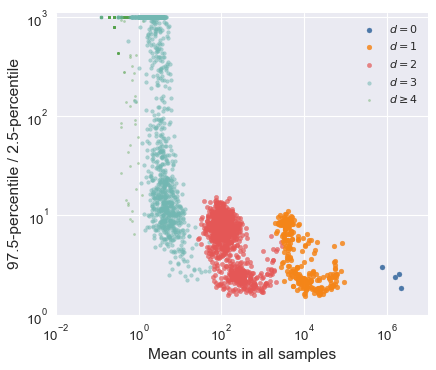

In [22]:
load_variant_pool()

scatter_plot_results_on_mutation_dist(
    result=get_result_summary(data=variant_pool, result=variant_pool_res),
    x = 'mean_counts', y = 'kA_fold_range',
    x_label = 'Mean counts in all samples', y_label = '97.5-percentile / 2.5-percentile',
    x_log = True, y_log = True, x_lim = (1e-2, 1e7), y_lim = (1, 1.1e3),
    fontsize = 14, top_group_size = int(1e3), top_y_values = 1e3, figsize=(6, 5)
)

fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-6a.pdf')

### Figure 6b

In [23]:
load_enriched_pool()
load_variant_pool()

# only consider sequences with 2.5-percentile > baseline
baseline_kA = 0.124

enriched_pool_res_active = enriched_pool_res.summary[enriched_pool_res.summary['bs_kA_2.5%'] > baseline_kA]
variant_pool_res_active = variant_pool_res.summary[variant_pool_res.summary['bs_kA_2.5%'] > baseline_kA]

loading enriched_pool


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/experimental/byo-enriched/all-seq_bs-100...


enriched_pool_res found


INFO:root:'seqs.tar.gz' found


variant_pool found
variant_pool_res found


In [25]:
from scipy import stats

shared_seqs = set(enriched_pool_res_active.index) & set(variant_pool_res_active.index)
print(f"{len(shared_seqs)} sequences shared by two fittings")

mean_counts_enriched = enriched_pool.table.no_failed.reindex(shared_seqs).mean(axis=1)
mean_counts_variant = variant_pool.table.filtered.reindex(shared_seqs).mean(axis=1)
min_mean_counts = pd.DataFrame([mean_counts_variant, mean_counts_enriched]).min(axis=0)

# sequences with min mean_counts greater than 1000
min_mean_counts_large = min_mean_counts[min_mean_counts >= 1000]
corr_large = {
    'pearson r': stats.pearsonr(
        variant_pool_res_active.loc[min_mean_counts_large.index, 'kA'],
        enriched_pool_res_active.loc[min_mean_counts_large.index, 'kA']
    ),
    'spearman r': stats.spearmanr(
        variant_pool_res_active.loc[min_mean_counts_large.index, 'kA'],
        enriched_pool_res_active.loc[min_mean_counts_large.index, 'kA']
    )
}

print(f"""
{len(min_mean_counts_large)} sequences had min mean counts ≥ 1000
    pearson r:{corr_large['pearson r'][0]:.3f}, p-val: {corr_large['pearson r'][1]:.2e}
    spearman r:{corr_large['spearman r'][0]:.3f}, p-val: {corr_large['spearman r'][1]:.2e}
""")

# sequences with min mean_counts greater than 100

min_mean_counts_median = min_mean_counts[min_mean_counts >= 100]
corr_median = {
    'pearson r': stats.pearsonr(
        variant_pool_res_active.loc[min_mean_counts_median.index, 'kA'], 
        enriched_pool_res_active.loc[min_mean_counts_median.index, 'kA']),
    'spearman r': stats.spearmanr(
        variant_pool_res_active.loc[min_mean_counts_median.index, 'kA'],
        enriched_pool_res_active.loc[min_mean_counts_median.index, 'kA']
    )
}

print(f"""
{len(min_mean_counts_median)} sequences had min mean counts ≥ 100
    pearson r: {corr_median['pearson r'][0]:.3f}, p-val: {corr_median['pearson r'][1]:.2e}
    spearman r:{corr_median['spearman r'][0]:.3f}, p-val: {corr_median['spearman r'][1]:.2e}
""")

# sequences with min mean_counts less than 100
min_mean_counts_small = min_mean_counts[min_mean_counts < 100]
min_mean_counts_small = min_mean_counts_small[~(variant_pool_res_active.loc[min_mean_counts_small.index, 'kA'].isna() | enriched_pool_res_active.loc[min_mean_counts_small.index, 'kA'].isna())]

corr_small = {
    'pearson r': stats.pearsonr(
        variant_pool_res_active.loc[min_mean_counts_small.index, 'kA'], 
        enriched_pool_res_active.loc[min_mean_counts_small.index, 'kA']),
    'spearman r': stats.spearmanr(
        variant_pool_res_active.loc[min_mean_counts_small.index, 'kA'], 
        enriched_pool_res_active.loc[min_mean_counts_small.index, 'kA'])
}

print(f"""
{len(min_mean_counts_small)} sequences had min mean counts < 100
    pearson r: {corr_small['pearson r'][0]:.4f}, p-val: {corr_small['pearson r'][1]:.2e}
    spearman r: {corr_small['spearman r'][0]:.4f}, p-val: {corr_small['spearman r'][1]:.2e}
""")

2513 sequences shared by two fittings

39 sequences had min mean counts ≥ 1000
    pearson r:0.896, p-val: 1.20e-14
    spearman r:0.864, p-val: 1.38e-12


119 sequences had min mean counts ≥ 100
    pearson r: 0.183, p-val: 4.68e-02
    spearman r:0.460, p-val: 1.44e-07


2394 sequences had min mean counts < 100
    pearson r: -0.0234, p-val: 2.52e-01
    spearman r: 0.0505, p-val: 1.34e-02



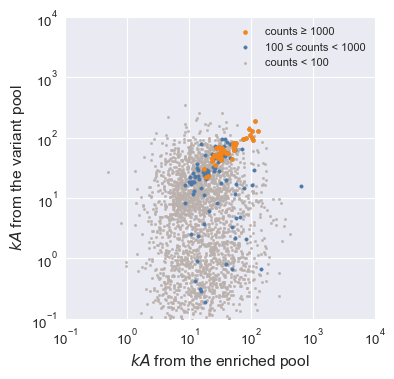

In [26]:
fontsize = 14

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

groups = {
    f"counts ≥ 1000": (min_mean_counts_large, '#F58518', 15),
    f"100 ≤ counts < 1000": (min_mean_counts_median, '#4C78A8', 10),
    f"counts < 100": (min_mean_counts_small, '#BAB0AC', 5)
}

for ix, (label, (seqs, color, s)) in enumerate(groups.items()):
    ax.scatter(enriched_pool_res_active['kA'][seqs.index], variant_pool_res_active['kA'][seqs.index],
               s=s, color=color, alpha=1, label=label, zorder=5 - ix)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=fontsize - 2)
ax.set_xlabel('$kA$ from the enriched pool', fontsize=fontsize)

ax.set_ylabel('$kA$ from the variant pool', fontsize=fontsize)
ax.set_xlim(1e-1, 1e4)
ax.set_ylim(1e-1, 1e4)
ax.legend(fontsize=fontsize - 4)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-6b.pdf', bbox_inches='tight')

plt.show()